In [1]:
# Unsupervised learning

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize': 20,
          'figure.figsize': (12, 8),
          'axes.labelsize': 20,
          'axes.titlesize': 24,
          'xtick.labelsize':16,
          'ytick.labelsize': 16}
mpl.rcParams.update(params)

%matplotlib inline

In [3]:
data = pd.read_csv("element_data.csv", index_col=0)
print(data)

             K       MP      BP   Z     X     r
Element                                        
Ac        29.0  1323.00  3573.0  89  1.10  1.95
Ag        88.0  1234.93  2435.0  47  1.93  1.60
Al        83.0   933.47  2792.0  13  1.61  1.25
As        40.0  1090.00   887.0  33  2.18  1.15
Au       137.0  1337.33  3129.0  79  2.54  1.35
...        ...      ...     ...  ..   ...   ...
W        304.0  3695.00  5828.0  74  2.36  1.35
Y         41.0  1799.00  3609.0  39  1.22  1.80
Yb        15.0  1097.00  1469.0  70  1.10  1.75
Zn        67.0   692.68  1180.0  30  1.65  1.35
Zr        94.0  2128.00  4682.0  40  1.33  1.55

[83 rows x 6 columns]


In [4]:
features = [c for c in data.columns if c != "K"]
x = data[features]
y = data["K"]

In [5]:
# Principal Component Analysis

In [17]:
# scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x)
means_ = scaler.mean_
stds_ = scaler.scale_
z = scaler.transform(x)
z

array([[-5.45729916e-02,  5.57123559e-01,  1.66453606e+00,
        -1.01314280e+00,  1.16750935e+00],
       [-1.51727935e-01, -1.96804156e-01,  3.59722921e-02,
         2.98800949e-01,  2.77321774e-01],
       [-4.84285326e-01,  3.97091957e-02, -1.28238886e+00,
        -2.07008688e-01, -6.12865800e-01],
       [-3.11608326e-01, -1.22235785e+00, -5.06882298e-01,
         6.93964728e-01, -8.67205107e-01],
       [-3.87647669e-02,  2.62972500e-01,  1.27678278e+00,
         1.26300057e+00, -3.58526493e-01],
       [ 1.07726501e+00,  9.72512554e-01, -1.59259148e+00,
         4.72673012e-01, -1.63022303e+00],
       [-4.10892361e-01, -3.90254852e-01,  3.84950243e-01,
        -1.34508037e+00,  1.67618796e+00],
       [ 2.06874967e-01,  6.58407642e-03, -1.63136681e+00,
        -2.70234893e-01, -1.12154441e+00],
       [-9.13490209e-01, -5.92980582e-01,  1.43188410e+00,
         4.41059910e-01,  2.77321774e-01],
       [-1.22082945e+00, -1.59004667e+00, -4.29331642e-01,
         1.92687572e+00

In [7]:
# PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(z)
z_pca = pca.transform(z)
print(pca.explained_variance_)

[2.48129526 1.66162933 0.70991635 0.12338667 0.08474801]


C:\Users\YoYo\miniconda3\envs\nano281\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


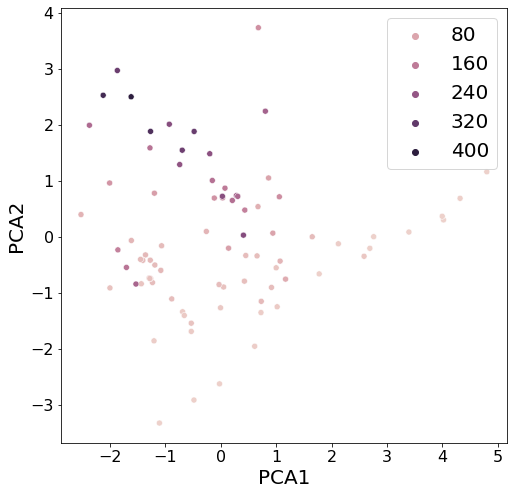

In [8]:
# plot only the first two PCA components
plt.figure(figsize=(8, 8))
sns.scatterplot(z_pca[:, 0], z_pca[:, 1], hue=y)
plt.legend(loc="best")
plt.xlabel("PCA1")
plt.ylabel("PCA2");

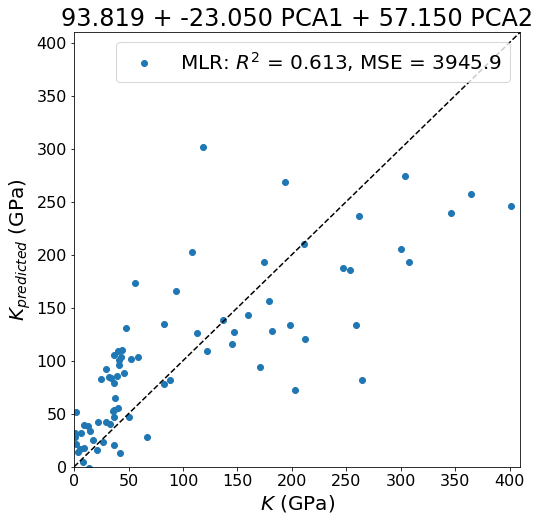

In [9]:
# linear regression on the first two PCA components
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mlr = linear_model.LinearRegression()
yhat_mlr = cross_val_predict(mlr, z_pca[:, 0:2], y, cv=kfold)
r2_mlr = r2_score(y, yhat_mlr)
mae_mlr = mean_squared_error(y, yhat_mlr)
label_mlr = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_mlr, mae_mlr)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--')

mlr.fit(z_pca[:, 0:2], y)
equation = "%.3f + %.3f PCA1 + %.3f PCA2" % (mlr.intercept_, *mlr.coef_)
plt.title(equation);

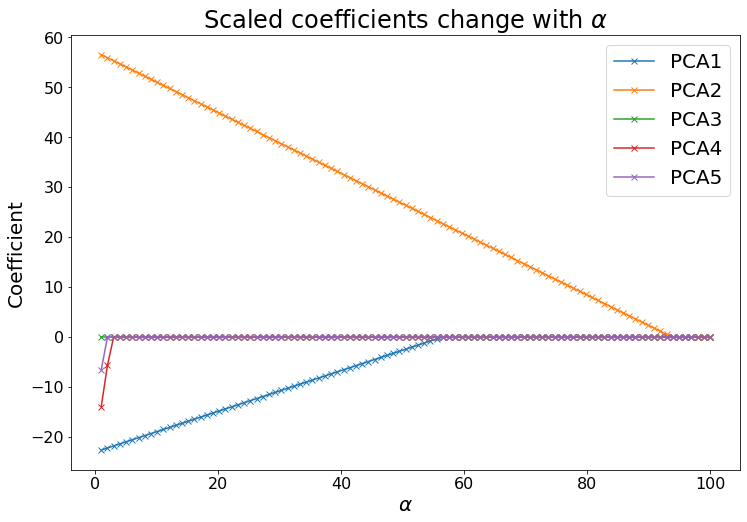

In [10]:
# lasso on the full PCA
from sklearn.model_selection import cross_validate

features = ["PCA%d" % (i+1) for i in range(5)]
alphas = np.linspace(1, 100, 99)
cv_results = []
coeffs = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=100000)
    lasso.fit(z_pca, y)
    scores = cross_validate(lasso, z_pca, y, cv=kfold, scoring='neg_mean_squared_error')
    cv_results.append([alpha, -np.mean(scores["test_score"])] + list(lasso.coef_))

cv_results = pd.DataFrame(cv_results, columns=["alpha", "score"] + features)
f, ax = plt.subplots(figsize=(12, 8))
for f in features:
    plt.plot(cv_results["alpha"], cv_results[f], '-x', label=f)
    #plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Coefficient')
    plt.title(r'Scaled coefficients change with $\alpha$')
plt.legend();

In [11]:
# Clustering

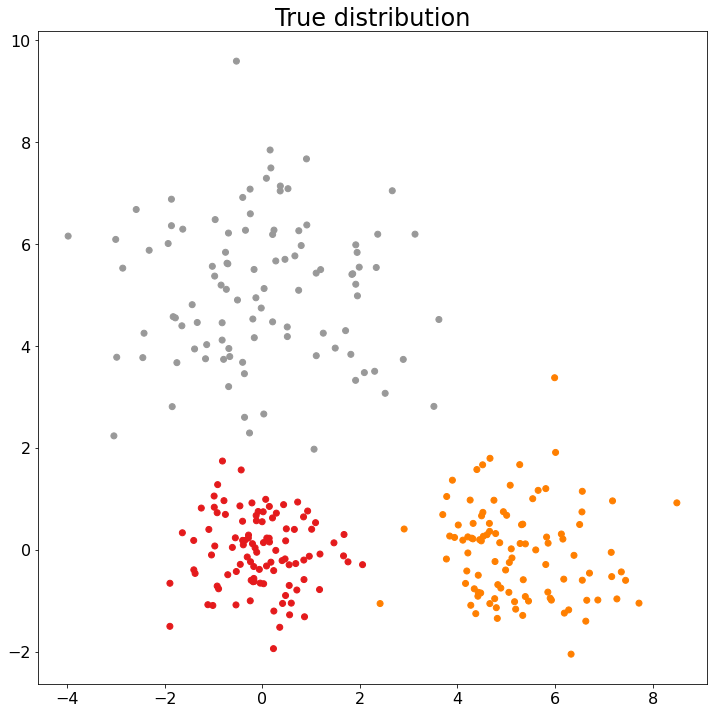

In [12]:
import numpy as np

data = []
centers = [[0, 0], [5, 0], [0, 5]]
stds = [0.75, 1, 1.5]
labels = []
fig, ax = plt.subplots(figsize=(12, 12))
for i, (c, std) in enumerate(zip(centers, stds)):
    points = np.random.randn(100, 2) * std + c
    labels.extend([i] * 100)
    data.extend(points)
data = np.array(data)
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='Set1')
ax.set_title("True distribution")
np.savetxt("3_gaussians.txt", data)

In [13]:
# K-means

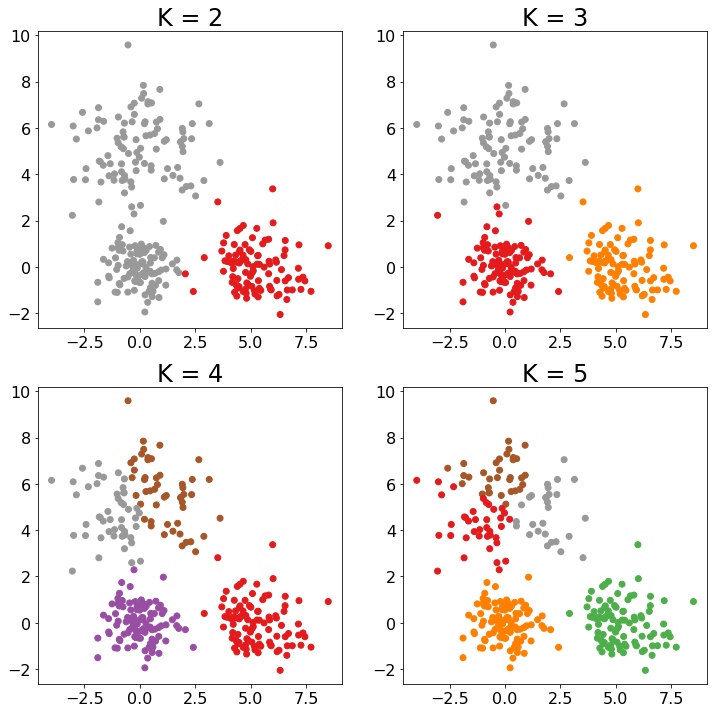

In [14]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i, k in enumerate(range(2, 6)):
    clustering = KMeans(k).fit(data)
    a = ax[0 if i < 2 else 1, i % 2]
    a.scatter(data[:, 0], data[:, 1], c=clustering.labels_, cmap='Set1')
    a.set_title("K = %d" % k)

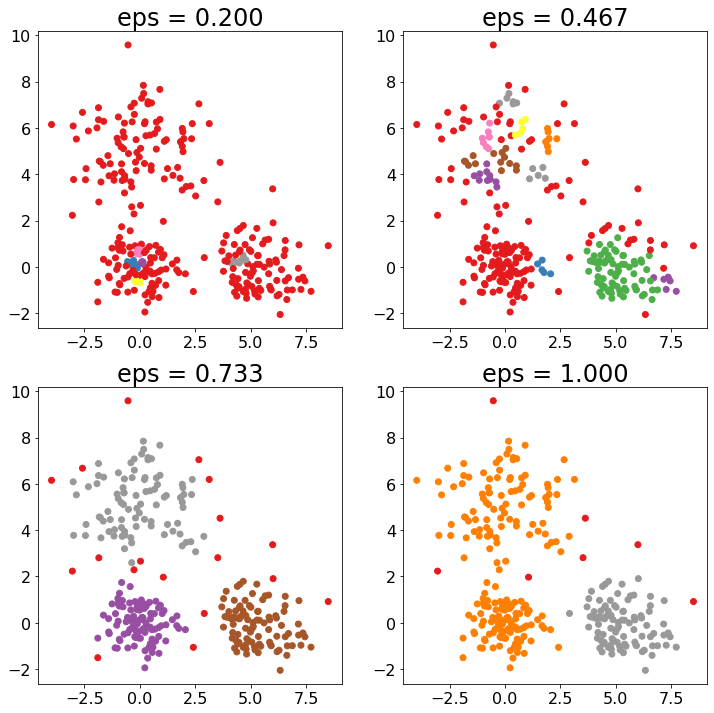

In [15]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i, eps in enumerate(np.linspace(0.2, 1, 4)):
    clustering = DBSCAN(eps=eps).fit(data)
    a = ax[0 if i < 2 else 1, i % 2]
    a.scatter(data[:, 0], data[:, 1], c=clustering.labels_, cmap='Set1')
    a.set_title("eps = %.3f" % eps)

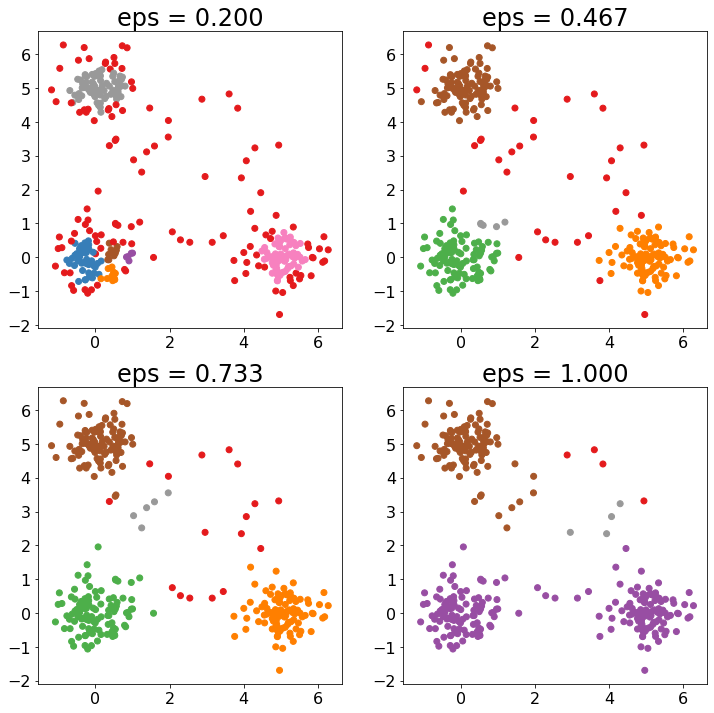

In [16]:
data = []
centers = [[0, 0], [5, 0], [0, 5]]
stds = [0.5, 0.5, 0.5]
labels = []
for i, (c, std) in enumerate(zip(centers, stds)):
    points = np.random.randn(100, 2) * std + c
    labels.extend([i] * 100)
    data.extend(points)
noise = np.random.rand(30, 2) * 5
data.extend(noise)
data = np.array(data)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i, eps in enumerate(np.linspace(0.2, 1, 4)):
    clustering = DBSCAN(eps=eps).fit(data)
    a = ax[0 if i < 2 else 1, i % 2]
    a.scatter(data[:, 0], data[:, 1], c=clustering.labels_, cmap='Set1')
    a.set_title("eps = %.3f" % eps)